In [1]:
import os

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import lib

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc9/texlive/2024/bin/x86_64-linux"

In [5]:
truth_ids = lib.truth.get_truth_ids()

In [6]:
deepfield_ids = lib.deepfield.get_deepfield_ids()

In [7]:
_, truth_indices, deepfield_indices = np.intersect1d(
    truth_ids,
    deepfield_ids,
    return_indices=True,
)

In [8]:
truth_indices.max(), len(truth_ids)

(221539, 223007)

In [9]:
n_truth = len(truth_ids)

In [10]:
# in truth, not in deepfield
n_unmatched = len(
    np.setdiff1d(
        truth_ids,
        deepfield_ids,
    )
)
print(f"{n_unmatched}/{n_truth} [{n_unmatched / n_truth * 100 :.2f}%] objects in truth table but not deepfield table")

20774/223007 [9.32%] objects in truth table but not deepfield table


In [11]:
truth_table = lib.truth.get_truth_table()

In [12]:
deepfield_table = lib.deepfield.get_deepfield_table()

In [13]:
for band in lib.const.BANDS:
    np.testing.assert_allclose(
        truth_table[f"mag_{band}"][truth_indices],
        deepfield_table[f"MAG_{band}"][deepfield_indices],
    )

# Use direct matches; leave nans

In [14]:
out_table = {}

out_table["z"] = np.full(n_truth, np.nan)
out_table["z"][truth_indices] = truth_table["photoz"][truth_indices]

for i, (truth_band, deepfield_band) in enumerate(zip(lib.const.TRUTH_BANDS, lib.const.DEEPFIELD_BANDS)):
    out_table[f"DEEP:flux_{deepfield_band}"] = np.full(n_truth, np.nan)
    out_table[f"DEEP:flux_{deepfield_band}"][truth_indices] = truth_table[f"flux_{truth_band}"][truth_indices]
    
    _mag = deepfield_table[f"MAG_{deepfield_band}"][deepfield_indices]
    _mag_err = deepfield_table[f"ERR_MAG_{deepfield_band}"][deepfield_indices]
    
    _flux, _flux_err = lib.util.mag_to_flux_with_error(_mag, _mag_err)
    
    out_table[f"DEEP:flux_err_{deepfield_band}"] = np.full(n_truth, np.nan)
    out_table[f"DEEP:flux_err_{deepfield_band}"][truth_indices] = _flux_err


In [15]:
# percent with match (remainder is nan)
np.sum(~np.isnan(out_table["DEEP:flux_r"])) / len(out_table["DEEP:flux_r"]) * 100

90.02677046012009

In [16]:
direct_match_with_nan = out_table

# Use direct matches; fill in with median

In [17]:
out_table = {}

out_table["z"] = np.full(n_truth, np.nan)
out_table["z"][:] = truth_table["photoz"][:]

for i, (truth_band, deepfield_band) in enumerate(zip(lib.const.TRUTH_BANDS, lib.const.DEEPFIELD_BANDS)):
    out_table[f"DEEP:flux_{deepfield_band}"] = truth_table[f"flux_{truth_band}"]
    
    _mag = deepfield_table[f"MAG_{deepfield_band}"]
    _mag_err = deepfield_table[f"ERR_MAG_{deepfield_band}"]
    
    _flux, _flux_err = lib.util.mag_to_flux_with_error(_mag, _mag_err)
    
    _med_flux_err = np.median(_flux_err)
    
    out_table[f"DEEP:flux_err_{deepfield_band}"] = np.full(n_truth, _med_flux_err)
    out_table[f"DEEP:flux_err_{deepfield_band}"][truth_indices] = _flux_err[deepfield_indices]


In [18]:
direct_match_with_median = out_table

# Use KNN

In [19]:
knn = lib.deepfield.get_knn()

In [20]:
_X = np.array(
    [
        truth_table[f"flux_{band}"]
        for band in lib.const.TRUTH_BANDS
    ]
).T

In [21]:
y = knn.predict(_X)

In [22]:
out_table = {}

out_table["z"] = truth_table["photoz"]

for i, band in enumerate(lib.const.DEEPFIELD_BANDS):
    out_table[f"DEEP:flux_{band}"] = _X[:, i]
    
    out_table[f"DEEP:flux_err_{band}"] = y[:, i]

In [23]:
truth_match_filename = "truth-match.hdf5"
truth_match_file = os.path.join(
    "/pscratch/sd/s/smau/y6-image-sims-matches",
    truth_match_filename,
)

with h5py.File(truth_match_file, "w") as hf:
    for k, v in out_table.items():
        hf.create_dataset(k, data=v)

In [24]:
knn_match = out_table

---

In [25]:
_mag = deepfield_table["MAG_r"]
_mag_err = deepfield_table["ERR_MAG_r"]

_flux, _flux_err = lib.util.mag_to_flux_with_error(_mag, _mag_err)

_med_flux_err = np.median(_flux_err)

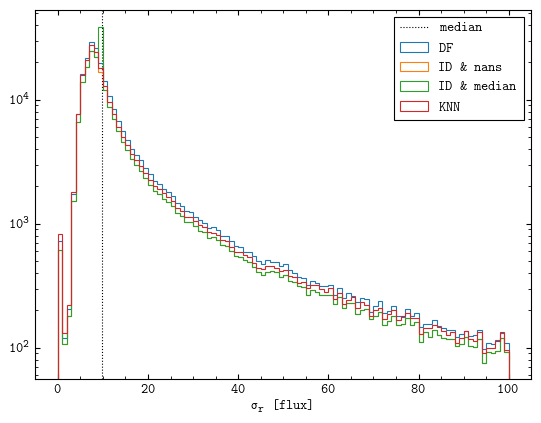

In [26]:
bins = np.linspace(0, 100, 101)

plt.axvline(_med_flux_err, ls=":", label="median")
plt.hist(
    _flux_err,
    histtype="step",
    label="DF",
    bins=bins,
)
plt.hist(
    direct_match_with_nan[f"DEEP:flux_err_r"],
    histtype="step",
    label="ID \& nans",
    bins=bins,
)
plt.hist(
    direct_match_with_median[f"DEEP:flux_err_r"],
    histtype="step",
    label="ID \& median",
    bins=bins,
)
plt.hist(
    knn_match[f"DEEP:flux_err_r"],
    histtype="step",
    label="KNN",
    bins=bins,
)
plt.xlabel("$\\sigma_r$ [flux]")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

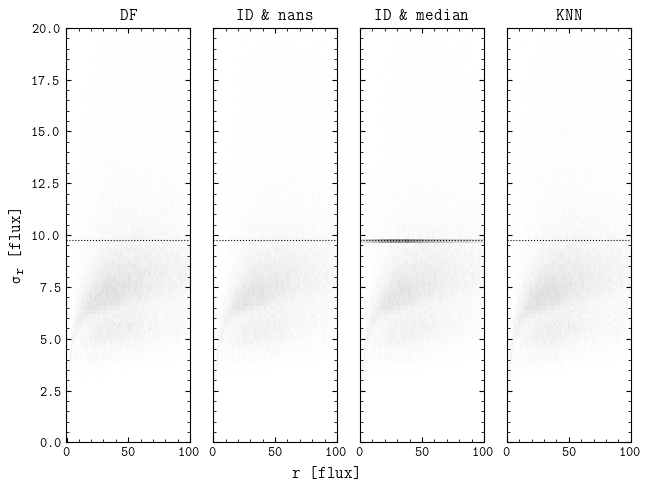

In [27]:
bins = [np.linspace(0, 100, 101), np.linspace(0, 20, 101)]

norm = plt.Normalize()

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, constrained_layout=True)
    
axs[0].hist2d(
    _flux,
    _flux_err,
    bins=bins,
    norm=norm,
)
axs[0].set_title("DF")

axs[1].hist2d(
    direct_match_with_nan[f"DEEP:flux_r"],
    direct_match_with_nan[f"DEEP:flux_err_r"],
    bins=bins,
    norm=norm,
)
axs[1].set_title("ID \& nans")

axs[2].hist2d(
    direct_match_with_median[f"DEEP:flux_r"],
    direct_match_with_median[f"DEEP:flux_err_r"],
    bins=bins,
    norm=norm,
)
axs[2].set_title("ID \& median")

axs[3].hist2d(
    knn_match[f"DEEP:flux_r"],
    knn_match[f"DEEP:flux_err_r"],
    bins=bins,
    norm=norm,
)
axs[3].set_title("KNN")

for ax in axs:
    ax.axhline(_med_flux_err, ls=":")

fig.supxlabel("$r$ [flux]")
fig.supylabel("$\\sigma_r$ [flux]")

plt.show()